In [2]:
import pandas as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [3]:
df_clean = pd.read_pickle('df_clean_final.pkl')

df_clean

,age,sex,bmi,children,smoker,charges,is_southwest,is_southeast,is_northwest,is_northeast,age_cat,18_35,36_50,51_70,71_200,bmi_cat,underweight,normal,overweight,obesity
0,19,0,27.900,0,1,16884.92400,1,0,0,0,18_35,1,0,0,0,overweight,0,0,1,0
1,18,1,33.770,1,0,1725.55230,0,1,0,0,18_35,1,0,0,0,obesity,0,0,0,1
2,28,1,33.000,3,0,4449.46200,0,1,0,0,18_35,1,0,0,0,obesity,0,0,0,1
3,33,1,22.705,0,0,21984.47061,0,0,1,0,18_35,1,0,0,0,normal,0,1,0,0
4,32,1,28.880,0,0,3866.85520,0,0,1,0,18_35,1,0,0,0,overweight,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1333,50,1,30.970,3,0,10600.54830,0,0,1,0,36_50,0,1,0,0,obesity,0,0,0,1
1334,18,0,31.920,0,0,2205.98080,0,0,0,1,18_35,1,0,0,0,obesity,0,0,0,1
1335,18,0,36.850,0,0,1629.83350,0,1,0,0,18_35,1,0,0,0,obesity,0,0,0,1
1336,21,0,25.800,0,0,2007.94500,1,0,0,0,18_35,1,0,0,0,overweight,0,0,1,0


# Regression lineaire simple

## Regression BMI/Charges

In [7]:
y=df_clean[['charges']]
X = df_clean[['bmi','age','smoker','sex','children']]

# regression lineaire, calcule R2, scatterplot
model = LinearRegression()
model.fit(X,y)
model.score(X,y)
print("R2 (coefficient de détermination): ",model.score(X,y))
model.predict(X)
# plt.scatter(X,y)
# plt.plot(X,model.predict(X),c='r')

#calcul RSME

rsme= np.sqrt(mean_squared_error(y,model.predict(X)))
print("RSME: ",rsme)

R2 (coefficient de détermination):  0.7495540902592981
RSME:  6058.310641972325


En calculant ces deux métriques nous pouvons dire que notre algorithme se trompe en moyenne de 11865.17€ et que 3.94% de la variation de la charge est expliqué par le BMI.

R2 (coefficient de détermination):  0.8282046626546052
RSME:  6059.512779948276


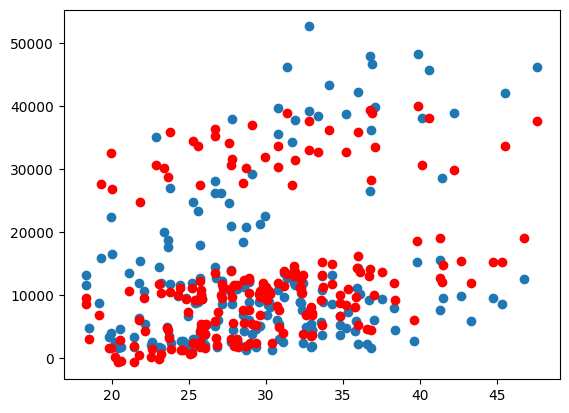

In [14]:
from sklearn.model_selection import train_test_split

y=df_clean[['charges']]
X = df_clean[['bmi','age','smoker','sex','children']]

# regression lineaire, calcule R2, scatterplot

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, train_size=0.85, random_state=42, stratify=X['smoker'])

model = LinearRegression()
model.fit(X_train,y_train)
model.score(X_train,y_train)
print("R2 (coefficient de détermination): ",model.score(X_test,y_test))

y_pred=model.predict(X_test)

plt.scatter(X_test['bmi'],y_test)

plt.scatter(X_test['bmi'],y_pred,color='red')
# plt.plot(X,model.predict(X),c='r')

#calcul RSME

rmse= np.sqrt(mean_squared_error(y,model.predict(X)))
print("RSME: ",rmse)

### Regression ElasticNet

In [30]:
from sklearn.linear_model import ElasticNet

y=df_clean[['charges']]
X = df_clean[['bmi','age','smoker','sex','children']]
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, train_size=0.85, random_state=0)

model= ElasticNet (alpha=1, l1_ratio =0.5)
model.fit(X_train, y_train)
score = model.score(X_test, y_test)
print(score)
y_pred = model.predict(X_test)



0.4132672194239573


### Regression Lasso

In [29]:

from sklearn.linear_model import Lasso

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, train_size=0.85, random_state=0)
lasso = Lasso(alpha=1.0)
lasso.fit(X_train, y_train)
print(y_train.shape)
print(X_train.shape)
# y_pred = lasso.predict(X_test)
score = lasso.score(X_test,y_test)

score

(1136, 1)
(1136, 5)


0.7329541655792376

### Regression Ridge

In [25]:
from sklearn.linear_model import Ridge

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, train_size=0.85, random_state=0)
ridge = Ridge(alpha=1.0)
ridge.fit(X_train,y_train)
score= ridge.score(X_test,y_test)
score


0.7330458256282031